### Research Question ###
What factors (such as model year, manufacturer brand, and electric range) are associated with higher electric vehicle (EV) registrations across different counties in Washington State?

### Data Description ###
We are using a dataset that shows the Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) that are currently registered through Washington State Department of Licensing (DOL). It provides key information about vehicle registrations, tax exemptions, and eligibility criteria for clean alternative fuel vehicles, and is updated regularly, with the monthly vehicle count subject to changes due to county assignment processes during registration. A Battery Electric Vehicle (BEV) is an all-electric vehicle using one or more batteries to store the electrical energy that powers the motor and is charged by plugging the vehicle in to an electric power source. A Plug-in Hybrid Electric Vehicle (PHEV) is a vehicle that uses one or more batteries to power an electric motor; uses another fuel, such as gasoline or diesel, to power an internal combustion engine or other propulsion source; and is charged by plugging the vehicle in to an electric power source.

The dataset consists of several columns representing various attributes related to each electric vehicle, including:
VIN: Vehicle Identification Number; County: The county where the vehicle is registered; City: The city where the vehicle is registered; State: The state (WA for Washington); Postal Code: The postal code of the registration; Model Year: The year the vehicle model was manufactured; Make: The manufacturer brand of the vehicle; Model: The model of the vehicle

#### Data Limitations ####
There are some limitations in our dataset.
1. Missing Values: Some fields may contain missing values, particularly for Electric Range and Base MSRP.
2. The presence of outliers in the Base MSRP and Electric Range columns may skew results and influence statistical analyses.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb
from sklearn.linear_model import LinearRegression

In [54]:
ev_df = pd.read_csv('Electric_Vehicle_Population_Data.csv', encoding='ISO-8859-1')
print(ev_df.shape)
ev_df.head()

(177866, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,7SAYGDEE9P,Snohomish,Bothell,WA,98021.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,1.0,244285107,POINT (-122.179458 47.802589),PUGET SOUND ENERGY INC,5.306105e+10
2,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,POINT (-122.34848 47.632405),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,POINT (-122.03646 47.534065),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,5YJYGDEE5M,Kitsap,Suquamish,WA,98392.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,23.0,205138552,POINT (-122.55717 47.733415),PUGET SOUND ENERGY INC,5.303594e+10


#### Computing summary statistics ####

In [12]:
summary_statistics = ev_df[['Model Year', 'Electric Range']].describe()
print("Summary Statistics:\n", summary_statistics)

Summary Statistics:
          Model Year  Electric Range
count  85911.000000     85911.00000
mean    2018.437499       121.81276
std        3.074840        99.21698
min     1997.000000         6.00000
25%     2017.000000        32.00000
50%     2018.000000        84.00000
75%     2020.000000       215.00000
max     2024.000000       337.00000


In [16]:
make_counts = ev_df['Make'].value_counts()
print("\nCount of EV registrations by manufacturer:\n", make_counts)


Count of EV registrations by manufacturer:
 Make
TESLA                   25578
NISSAN                  10781
CHEVROLET                9358
TOYOTA                   6006
BMW                      5613
JEEP                     4480
FORD                     3929
KIA                      3843
CHRYSLER                 2993
VOLVO                    2711
AUDI                     2159
VOLKSWAGEN               1067
MITSUBISHI                958
HYUNDAI                   922
HONDA                     833
FIAT                      784
PORSCHE                   713
DODGE                     568
MAZDA                     472
MERCEDES-BENZ             446
MINI                      342
SMART                     270
LINCOLN                   267
JAGUAR                    202
LEXUS                     188
POLESTAR                  143
CADILLAC                   92
SUBARU                     66
LAND ROVER                 56
ALFA ROMEO                 39
FISKER                     13
AZURE DYNAMICS      

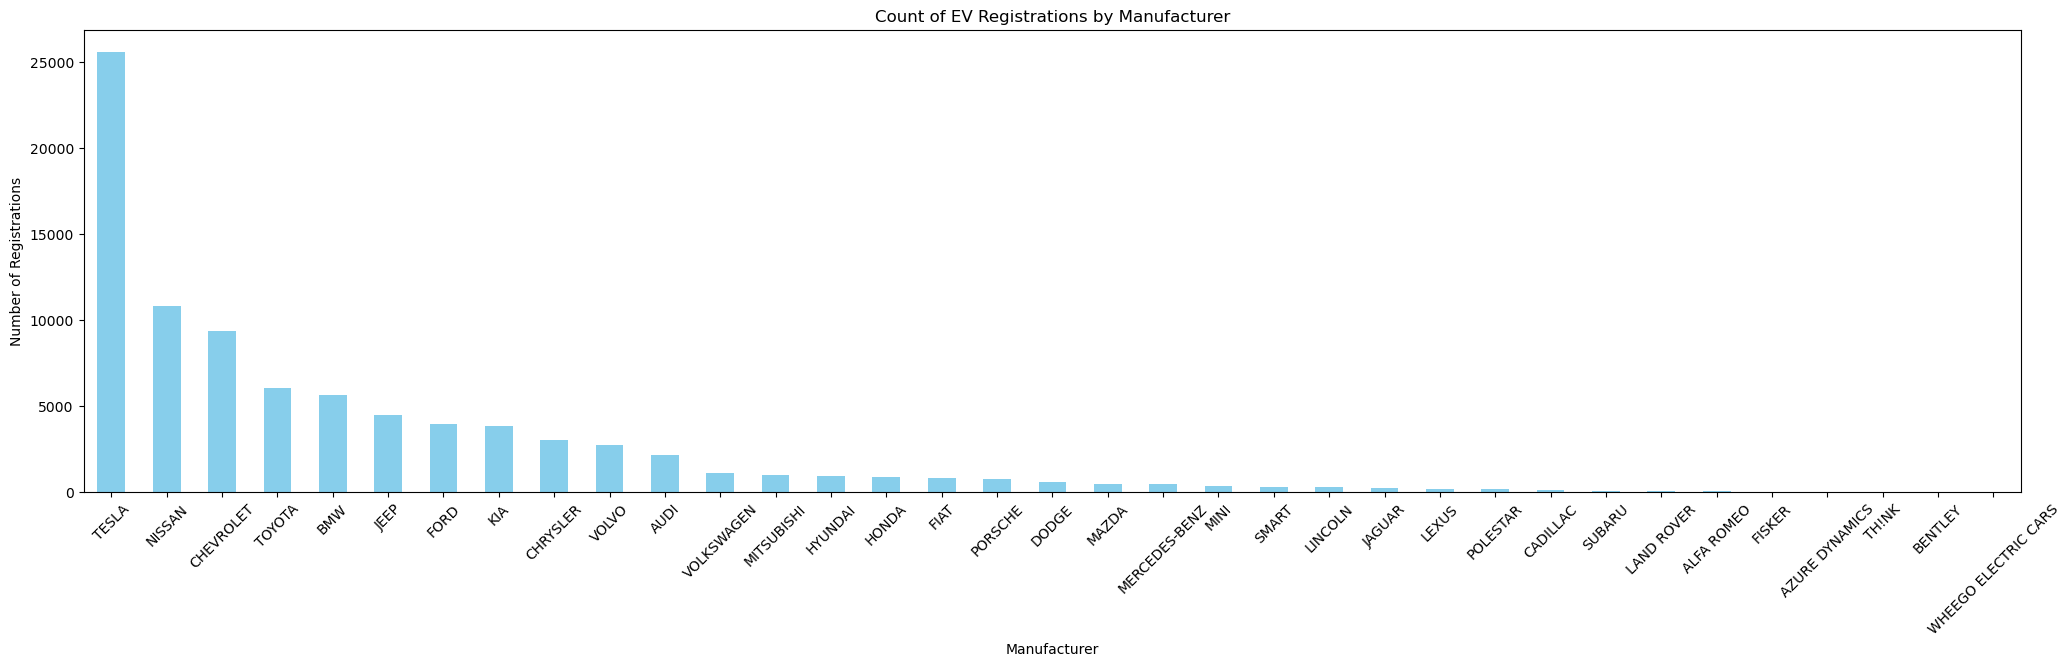

In [59]:
plt.figure(figsize=(25, 6))
make_counts.plot(kind='bar', color='skyblue')
plt.title('Count of EV Registrations by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.show()

In [17]:
type_counts = ev_df['Electric Vehicle Type'].value_counts()
print("\nCount of EV registrations by manufacturer:\n", type_counts)


Count of EV registrations by manufacturer:
 Electric Vehicle Type
Battery Electric Vehicle (BEV)            47255
Plug-in Hybrid Electric Vehicle (PHEV)    38656
Name: count, dtype: int64


In [19]:
year_counts = ev_df['Model Year'].value_counts().sort_index()
print("\nCount of EV registrations by Model Year:\n", year_counts)


Count of EV registrations by Model Year:
 Model Year
1997        1
1998        1
1999        5
2000        7
2002        2
2003        1
2008       19
2010       23
2011      775
2012     1618
2013     4408
2014     3509
2015     4844
2016     5483
2017     8561
2018    14322
2019    10936
2020    11706
2021     4369
2022     4330
2023     7184
2024     3807
Name: count, dtype: int64


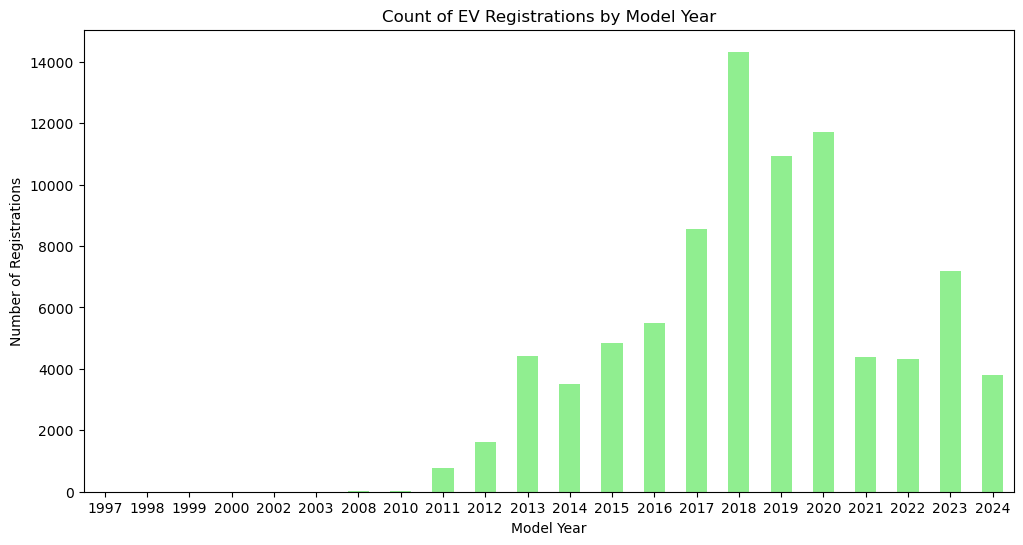

In [26]:
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='lightgreen')
plt.title('Count of EV Registrations by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=0)
plt.show()

In [3]:
ev_df = ev_df.dropna(subset=['County', 'Model Year', 'Make', 'Electric Vehicle Type', 'Electric Range'])
ev_df = ev_df[ev_df['Electric Range'] > 0]
ev_df['Model Year'] = ev_df['Model Year'].astype(int)

In [4]:
county_ev_counts = duckdb.query("""
    SELECT County, COUNT(*) AS "EV Count"
    FROM ev_df
    GROUP BY County
""").to_df()

merged_ev_df = duckdb.query("""
    SELECT a.*, b."EV Count"
    FROM ev_df AS a
    LEFT JOIN county_ev_counts AS b ON a.County = b.County
""").to_df()

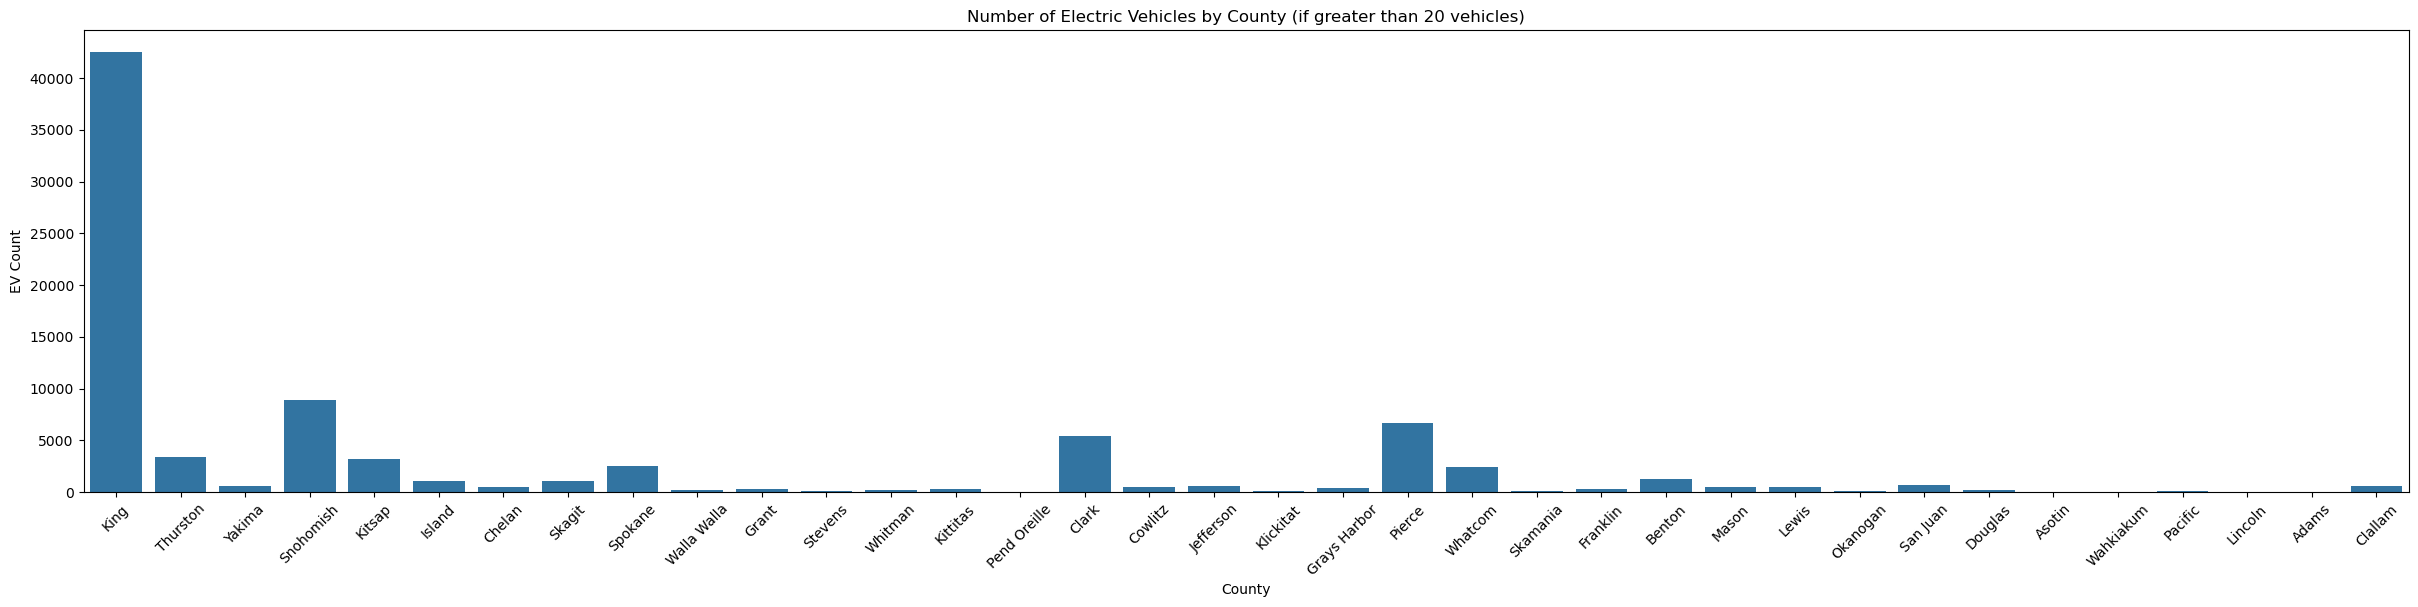

In [52]:
plt.figure(figsize=(30, 6))
merged_ev_df['EV Count >5'] = merged_ev_df['EV Count'] > 20
count_greater_than_5 = merged_ev_df[merged_ev_df['EV Count'] > 20]
sns.barplot(x='County', y= 'EV Count', data=count_greater_than_5, errorbar=None)
plt.xticks(rotation=45)
plt.title('Number of Electric Vehicles by County (if greater than 20 vehicles)')
plt.ylabel('EV Count')
plt.xlabel('County')
plt.show()

Text(0.5, 1.0, 'EV Count vs Electric Range')

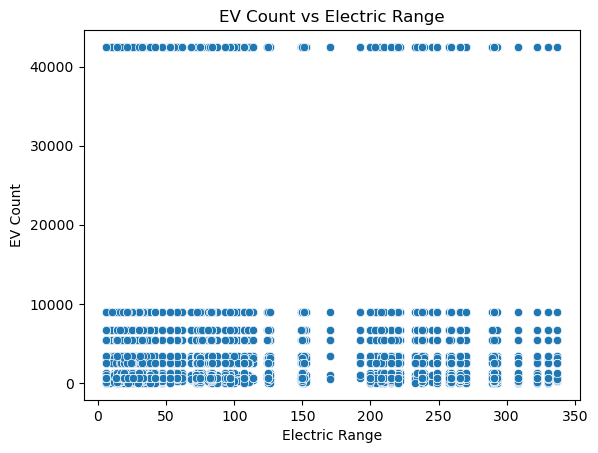

In [63]:
sns.scatterplot(x='Electric Range', y='EV Count', data=merged_ev_df)
plt.title('EV Count vs Electric Range')

Text(0.5, 1.0, 'EV Count vs Base MSRP')

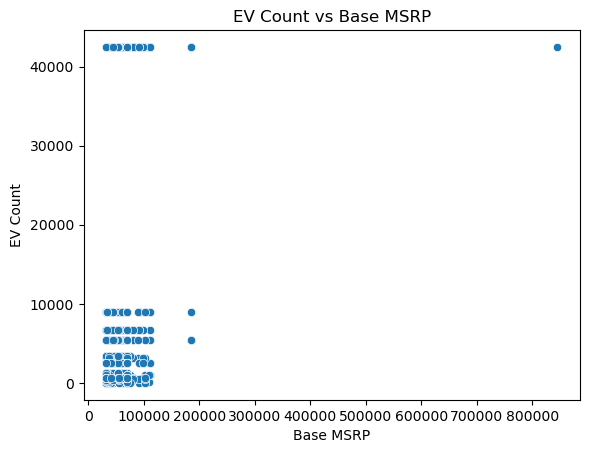

In [67]:
filtered_ev_df = merged_ev_df[merged_ev_df['Base MSRP'] >= 1000]
sns.scatterplot(x='Base MSRP', y='EV Count', data=filtered_ev_df)
plt.title('EV Count vs Base MSRP')

#### Regression Analysis ####

In [75]:
X = merged_ev_df[['Model Year', 'Electric Range']]
y = merged_ev_df['EV Count']

reg_model = LinearRegression()
reg_model.fit(X, y)

y_pred = reg_model.predict(X)
slope = reg_model.coef_
intercept = reg_model.intercept_

print("Slope", slope)
print("Intercept", intercept)


Slope [372.95955847  13.87070577]
Intercept -731210.4039241702


In [77]:
print(filtered_ev_df[['Model Year', 'Electric Range', 'Base MSRP', 'EV Count']].describe())

        Model Year  Electric Range      Base MSRP      EV Count
count  3343.000000     3343.000000    3343.000000   3343.000000
mean   2015.610529      121.766677   57065.725396  24141.869877
std       2.480740       89.987990   22787.416865  19013.611664
min    2008.000000       12.000000   31950.000000      1.000000
25%    2013.000000       17.000000   39995.000000   5410.000000
50%    2016.000000       93.000000   59900.000000  42481.000000
75%    2018.000000      208.000000   69900.000000  42481.000000
max    2020.000000      265.000000  845000.000000  42481.000000


In [76]:
X = filtered_ev_df[['Model Year', 'Electric Range', 'Base MSRP']]
y = filtered_ev_df['EV Count']

reg_model = LinearRegression()
reg_model.fit(X, y)

y_pred = reg_model.predict(X)
slope = reg_model.coef_
intercept = reg_model.intercept_

print("Slope", slope)
print("Intercept", intercept)


Slope [4.91726326e+02 1.33343384e+01 3.32860046e-02]
Intercept -970510.0586892858


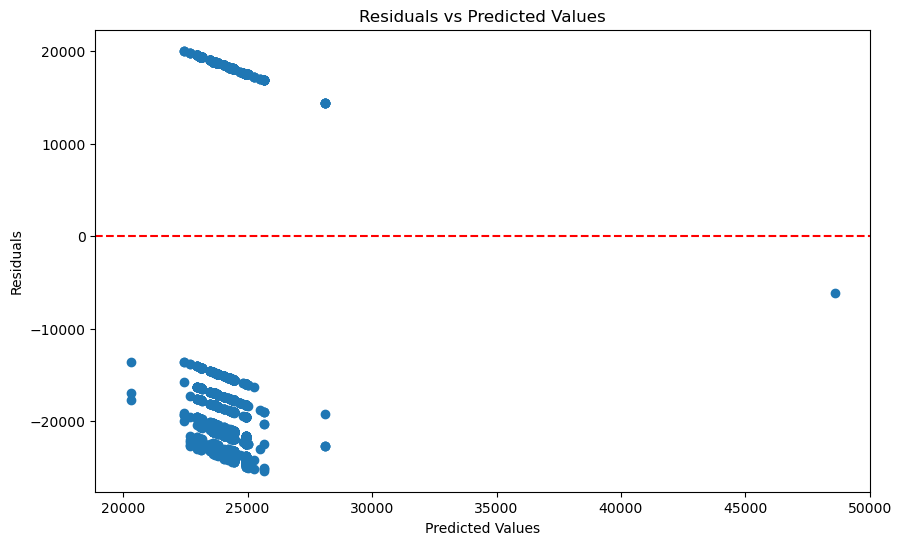

In [80]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

#### Correlation Analysis ####

In [71]:
correlation_matrix = filtered_ev_df[['EV Count', 'Electric Range', 'Base MSRP']].corr()
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
                 EV Count  Electric Range  Base MSRP
EV Count        1.000000        0.019425    0.03581
Electric Range  0.019425        1.000000    0.40572
Base MSRP       0.035810        0.405720    1.00000


#### Regression Results Interpretation ####
- The Model Year coefficient suggests that for each additional year in the model year, there is a significant positive increase in EV Count.
- The Electric Range coefficient indicates that for each additional mile of electric range, EV Count increases modestly.
- The intercept, when all independent variables are zero does not make much real-world sense.

#### Questions for Reviewers
1. What additional exploratory data analysis techniques would you suggest to uncover deeper insights?
2. Do you have recommendations for more advanced statistical methods or models that could improve the analysis?
3. Have we identified all relevant data limitations, or are there other concerns that I should consider?
